In [13]:
#math
import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [14]:
beta0 = 1.
beta1 = .5

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(500,)
(500, 2)
ModeResult(mode=array([0.]), count=array([49]))


In [15]:
np.random.seed()
yn,xn,nobs = gen_data()

In [16]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y)
        
       
        #if complete case, assign pr missing to all observations...
        pr_m = stats.norm.logcdf( y, loc = mu_y)
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
        
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        if ols: #if OLS use all the data...
            m, m_x = np.ones(y.shape), np.ones(x.shape)
        
        
        b = params

        beta_jac = np.zeros(len(b))
        
        #for censored
        if not ols: 
            left_stats = (y - np.dot(x, b)) 
            l_pdf = scipy.stats.norm.logpdf(left_stats)
            l_cdf = scipy.stats.norm.logcdf(left_stats)
            left_frac = np.exp(l_pdf - l_cdf)
            beta_left = np.dot(left_frac*m, x*m_x)
            beta_jac -= beta_left
        
        #for non-censored
        mid_stats = (y - np.dot(x, b))
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) )
        beta_jac += beta_mid
        
        # by chain rule, since the expression above is dloglik/dlogsigma
        return beta_jac



model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
print(model1_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                                Tobit Results                                 
Dep. Variable:                      y   Log-Likelihood:                -601.91
Model:                          Tobit   AIC:                             1208.
Method:            Maximum Likelihood   BIC:                             1216.
Date:                Wed, 17 Mar 2021                                         
Time:                        19:37:59                                         
No. Observations:                 500                                         
Df Residuals:                     498                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9700      0.071     13.696      0.000       0.831       1.109
x1             0.5078      0.010     52.609      0.0

In [17]:
model2 = sm.OLS(yn,sm.add_constant(xn))
model2_fit = model2.fit()
print(model2_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     3403.
Date:                Wed, 17 Mar 2021   Prob (F-statistic):          9.74e-225
Time:                        19:37:59   Log-Likelihood:                -666.42
No. Observations:                 500   AIC:                             1337.
Df Residuals:                     498   BIC:                             1345.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4116      0.056     25.254      0.0

# Create plots and stuff

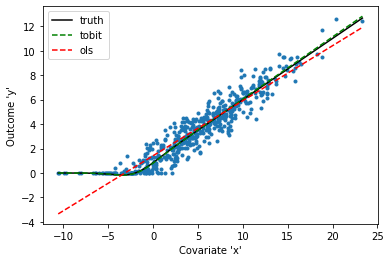

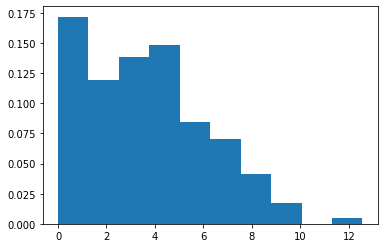

In [18]:
#create plot for true
plt.scatter(xn,yn,marker='.')
support_x = np.arange(xn.min(),xn.max(),.05)

#truth
pr_obs_true = stats.norm.cdf( beta0+beta1*support_x)
plt.plot(support_x, (beta0+beta1*support_x)*pr_obs_true ,label="truth",
         color='black')

#tobit
pr_obs_1 = stats.norm.cdf( model1_fit.params[0]+model1_fit.params[1]*support_x)
plt.plot(support_x, (model1_fit.params[0] + model1_fit.params[1]*support_x)*pr_obs_1 ,label="tobit",
         color='green',linestyle='--')

#ols
plt.plot(support_x, model2_fit.params[0] + model2_fit.params[1]*support_x ,label="ols",
         color='red',linestyle='--')



#create plot for normal
plt.ylabel("Outcome 'y'")
plt.xlabel("Covariate 'x'")
plt.legend()
plt.savefig('../figs/tobit_main.png')
plt.show()

plt.hist(yn,density=True)
plt.show()

In [7]:
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).sum() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).var() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).max() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).min() )


-15.513951356783988
0.016556920382202946
0.9792600126947617
-0.6178763888708163


# Complete case examples

In [8]:
y_cens, x_cens = yn[yn!=0],xn[yn!=0]
model3 = sm.OLS(y_cens,sm.add_constant(x_cens))
model3_fit = model3.fit()
print(model3_fit.summary())

model3 =  Tobit(yn,sm.add_constant(xn),cc=True)
model3_fit = model3.fit(disp=False)
print(model3_fit.summary())

print(np.log(yn[yn==0].shape[0]/1000)*yn[yn==0].shape[0] )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     1036.
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          6.81e-153
Time:                        12:01:38   Log-Likelihood:                -1271.6
No. Observations:                 922   AIC:                             2547.
Df Residuals:                     920   BIC:                             2557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2784      0.050     25.599      0.0

In [9]:
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).sum() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).var() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).max() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).min() )

61.57624586738285
0.19233691853032792
2.364487802090353
-2.818021367819912
